In [31]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import chardet
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense

In [8]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta LOCAL donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

def openFile(nomArch, sep=None):
    file = DATOS_DIR + nomArch
    #-- detectando la codificación de caracteres usada ----
    with open(file, 'rb') as f:
        result = chardet.detect(f.read()) 
    return pd.read_csv(file, encoding=result['encoding'], sep=sep, engine='python') # or readline if the file is large

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Ejercicio 1

In [7]:
nombre_archivo = DATOS_DIR + 'ecg.csv'

# carga archivo de datos. No tiene fila con titulos!
df= pd.read_csv(nombre_archivo, header=None)

raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


### Preparación de datos

In [8]:
# separa en etiquetas y datos
FEAT_CNT = 140

labels = raw_data[:, -1]    # Etiquetas (última columna)
data = raw_data[:, 0:-1]  # Datos (secuencia de 140 lecturas)

labels = labels.astype(int) # ajustas etiquetas porque tiene valores en punto flotante (0.0/1.0)

# separa en datos de entrenamiento y testeo
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=1
)

# Normalización de datos entre 0 y 1. Los datos son lecturas de una señal acotada en intensidad
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

normal_train_data = train_data[train_labels == 1]
normal_test_data = test_data[test_labels == 1]

anomal_train_data = train_data[train_labels == 0]
anomal_test_data = test_data[test_labels == 0]

### Visualizaciones de ejemplo

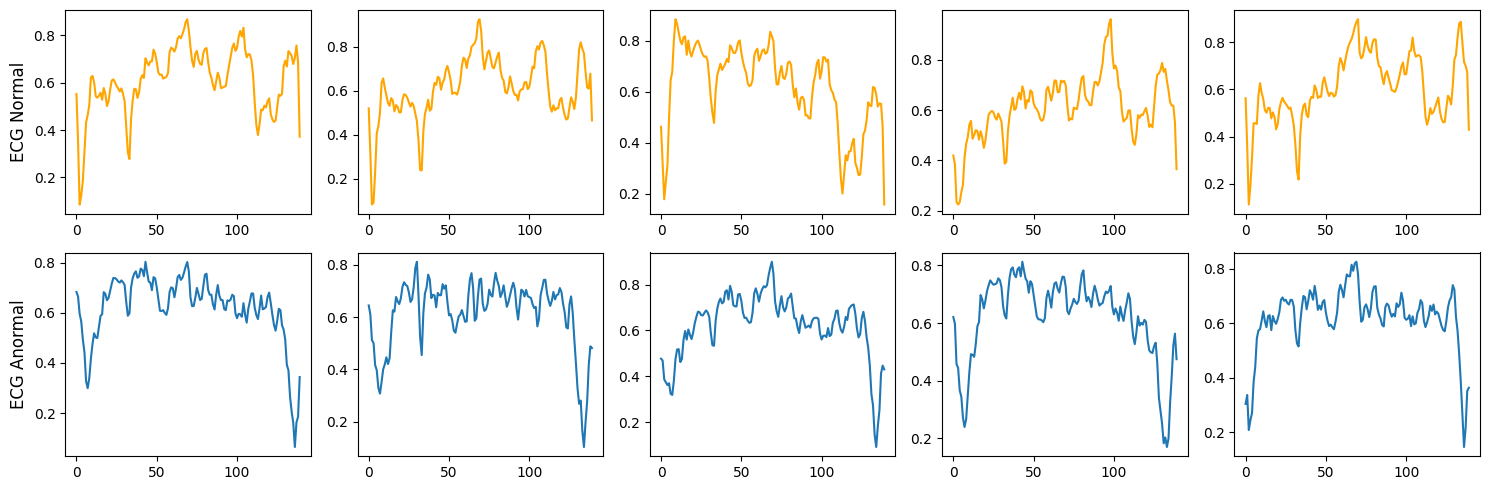

In [13]:
MOSTRAR = 5

fig, axs = plt.subplots(2, MOSTRAR, figsize=(15, 5))  # Ajusta el tamaño de la figura según sea necesario

for i in range(2):
    for j in range(MOSTRAR):
        if i == 0:
            axs[i, j].plot(np.arange(FEAT_CNT), normal_train_data[j], color='orange')  # Cambiar el color de la segunda fila a naranja
        else:
            axs[i, j].plot(np.arange(FEAT_CNT), anomal_train_data[j])  # Gráficos predeterminados para la primera fila

        #axs[i, j].spines['right'].set_visible(False)

# Agregar títulos
axs[0, 0].set_ylabel('ECG Normal' , fontsize=12)
axs[1, 0].set_ylabel('ECG Anormal', fontsize=12)

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()

### Construcción del Modelo

#### Compilación

In [14]:
from tensorflow.keras import layers, regularizers

# Codificador mejorado
encoder = tf.keras.Sequential([
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu")],  # Espacio latente más grande que 8 ----------- ¿Por qué? -----------
    name='Encoder'
)

# Decodificador mejorado
decoder = tf.keras.Sequential([
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dense(140, activation="sigmoid")],  # Mantenemos sigmoid para salida normalizada
    name='Decoder'
)

# Modelo completo del autoencoder
inputs = tf.keras.Input(shape=(140,))
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = tf.keras.Model( # Por qué decimos que es un modelo secuencial y no funcional?
    inputs=inputs,
    outputs=decoded,
    name='ECG_Autoencoder'
)

# Compilación con optimizador ajustado
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])


print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())


2025-10-22 06:28:05.843460: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,680 (115.94 KB)

 Trainable params: 29,296 (114.44 KB)

 Non-trainable params: 384 (1.50 KB)

None


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 140)            │        18,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,420 (114.92 KB)

 Trainable params: 29,228 (114.17 KB)

 Non-trainable params: 192 (768.00 B)

None


Model: "ECG_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Sequential)            │ (None, 16)             │        29,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 140)            │        29,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,100 (230.86 KB)

 Trainable params: 58,524 (228.61 KB)

 Non-trainable params: 576 (2.25 KB)

None


### Entrenamiento

In [15]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=10,         # Número de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaura los mejores pesos encontrados
)

history = autoencoder.fit(
    normal_train_data,
    normal_train_data, # Notesé que, al ser un autoencoder, los datos de entrada y salida son los mismos
    epochs=300,
    batch_size=64,
    validation_data=(test_data, test_data),
    shuffle=True,
    callbacks=[early_stopping],
    verbose=0
)

### Visualización de datos de entrenamiento

In [16]:
import plotly.graph_objects as go

fig = go.Figure()

# Recorre el historial para agregar todas las métricas automáticamente
for metric_name, metric_values in history.history.items():
    modo = 'lines' if 'loss' in metric_name else 'markers+lines'
    fig.add_trace(
        go.Scatter(
            y=metric_values,
            name=metric_name,
            mode=modo
        )
    )

fig.update_layout(
    title='Métricas de Entrenamiento',
    xaxis_title='Épocas',
    yaxis_title='Valor',
    template='plotly_white'
)

fig.show()

### Testeo

Ahora el autoencoder está entrenado para detectar valores normales de electrocardiogramas, entonces tenemos que ver que ocurre cuando se ingresan electrocardiogramas anormales.

#### Visualización de electrocardiogramas normales vs anormales

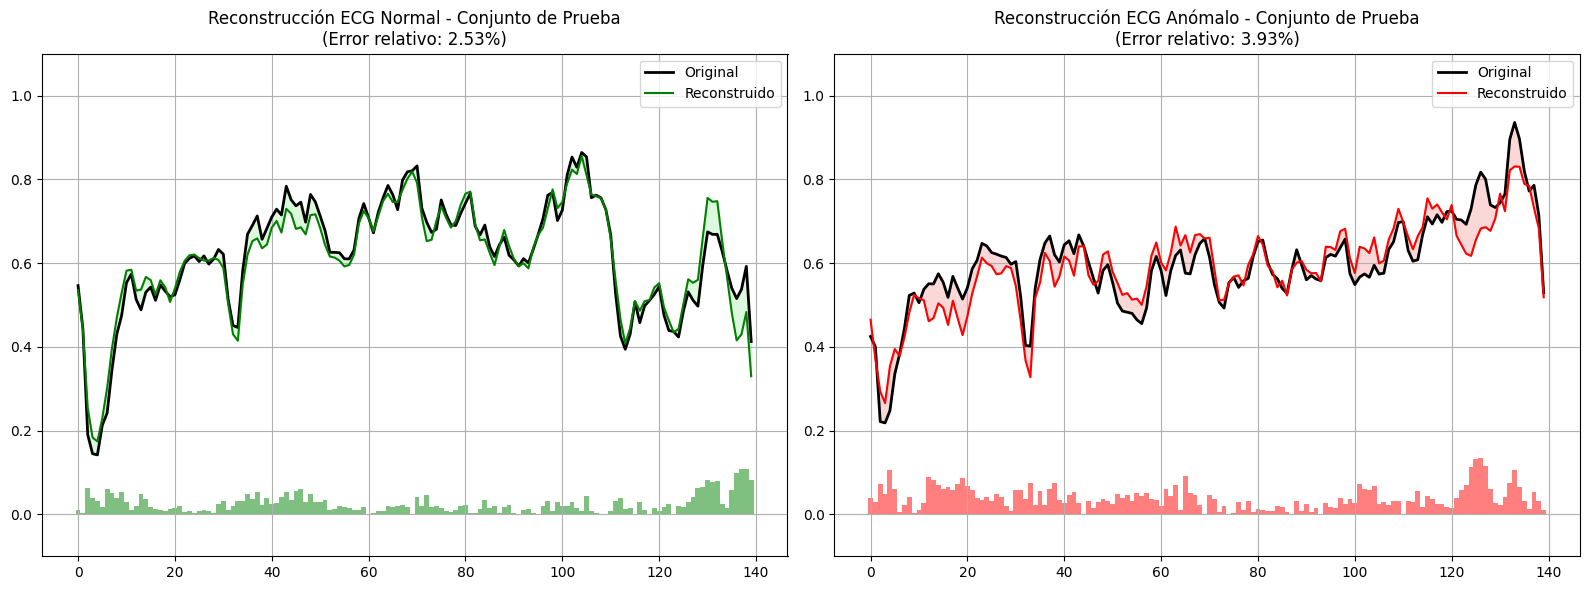

In [17]:
plt.figure(figsize=(16, 6))

# Calcula las reconstrucciones con el dataset de prueba
# ECG Normal
encoded_normal = encoder(normal_test_data).numpy()
decoded_normal = decoder(encoded_normal).numpy()

# ECG Anómalo
encoded_anomal = encoder(anomal_test_data).numpy()
decoded_anomal = decoder(encoded_anomal).numpy()

########## ECG Normal ##########
plt.subplot(1, 2, 1)
plt.title("Reconstrucción ECG Normal - Conjunto de Prueba\n(Error relativo: {:.2f}%)".format(
    100*np.mean(np.abs(normal_test_data[0] - decoded_normal[0]))))
plt.plot(normal_test_data[0], 'black', linewidth=2, label="Original")
plt.plot(decoded_normal[0], 'green', linewidth=1.5, label="Reconstruido")
plt.fill_between(np.arange(140), normal_test_data[0], decoded_normal[0],
                color='lightgreen', alpha=0.3)

# Error relativo por punto
point_error_normal = np.abs(normal_test_data[0] - decoded_normal[0])
plt.bar(np.arange(140), point_error_normal, color='green', alpha=0.5, width=1)

plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)

########## ECG Anómalo ###########
plt.subplot(1, 2, 2)
plt.title("Reconstrucción ECG Anómalo - Conjunto de Prueba\n(Error relativo: {:.2f}%)".format(
    100*np.mean(np.abs(anomal_test_data[0] - decoded_anomal[0]))))
plt.plot(anomal_test_data[0], 'black', linewidth=2, label="Original")
plt.plot(decoded_anomal[0], 'red', linewidth=1.5, label="Reconstruido")
plt.fill_between(np.arange(140), anomal_test_data[0], decoded_anomal[0],
                color='lightcoral', alpha=0.3)

# Grafica elrror relativo por punto
point_error_anomal = np.abs(anomal_test_data[0] - decoded_anomal[0])
plt.bar(np.arange(140), point_error_anomal, color='red', alpha=0.5, width=1)

plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

Luego se evaluan los errorres, indicando que media y desvío tienen, según si son normales o anormales. Esto nos va a permitir definir un umbral, el cual va a establecer (indirectamente) que grado de valores anormales queremos "perder" o "dejar pasar".

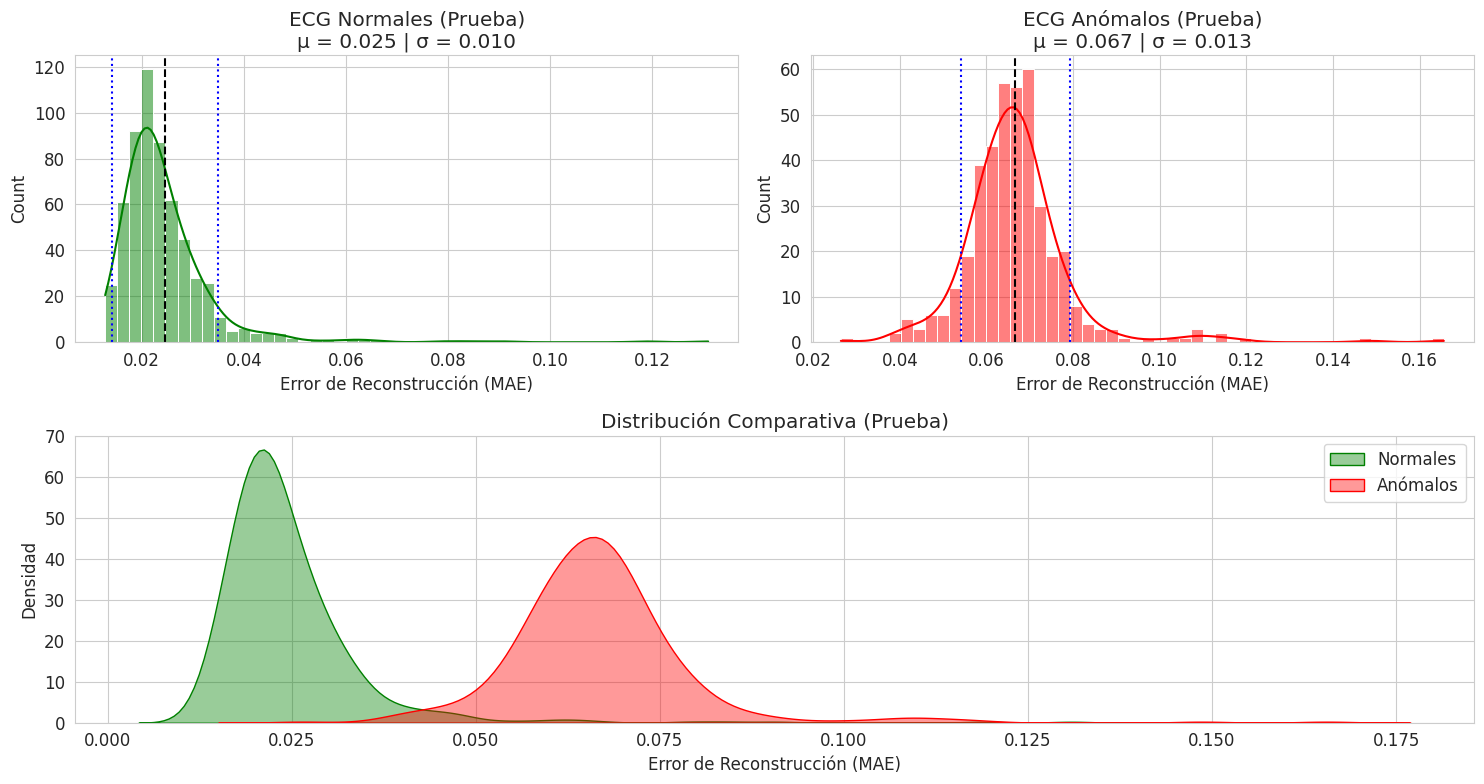

In [18]:
import matplotlib.pyplot as pltfuncional
import seaborn as sns
import numpy as np

# Configuración
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Calcula predicciones con datos de prueba
pred_normal = autoencoder.predict(normal_test_data, verbose=0)
pred_anormal = autoencoder.predict(anomal_test_data, verbose=0)

# Calcula errores de reconstrucción --- SOBRE ESTO SE HACEN LOS GRÁFICOS ---
prb_normal = tf.keras.losses.mae(pred_normal, normal_test_data)
prb_anomalo = tf.keras.losses.mae(pred_anormal, anomal_test_data)

# ########## Gráfico 1: Normales ##########
plt.subplot(2, 2, 1)

# calcula media y desvio sobre los ECG normales
media, desvio = np.mean(prb_normal), np.std(prb_normal)

sns.histplot(prb_normal, color='green', kde=True, bins=50)

plt.axvline(media, color='black', linestyle='--', linewidth=1.5)
plt.axvline(media + desvio, color='blue', linestyle=':', linewidth=1.5)
plt.axvline(media - desvio, color='blue', linestyle=':', linewidth=1.5)
plt.title(f'ECG Normales (Prueba)\nμ = {media:.3f} | σ = {desvio:.3f}')
plt.xlabel('Error de Reconstrucción (MAE)')

# ########## Gráfico 2: Anómalos ##########
plt.subplot(2, 2, 2)

# calcula media y desvio sobre los ECG normales
media, desvio = np.mean(prb_anomalo), np.std(prb_anomalo)

sns.histplot(prb_anomalo, color='red', kde=True, bins=50)

plt.axvline(media, color='black', linestyle='--', linewidth=1.5)
plt.axvline(media + desvio, color='blue', linestyle=':', linewidth=1.5)
plt.axvline(media - desvio, color='blue', linestyle=':', linewidth=1.5)
plt.title(f'ECG Anómalos (Prueba)\nμ = {media:.3f} | σ = {desvio:.3f}')
plt.xlabel('Error de Reconstrucción (MAE)')

# ########## Gráfico 3: Combinación ##########
plt.subplot(2, 1, 2)
sns.kdeplot(prb_normal, color='green', label='Normales', fill=True, alpha=0.4)
sns.kdeplot(prb_anomalo, color='red', label='Anómalos', fill=True, alpha=0.4)
plt.title('Distribución Comparativa (Prueba)')
plt.xlabel('Error de Reconstrucción (MAE)')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import confusion_matrix, classification_report

# Datos de prueba
y_true = np.concatenate([np.ones(len(prb_normal)), np.zeros(len(prb_anomalo))])
y_scores = np.concatenate([prb_normal, prb_anomalo])

# Función para actualizar el gráfico
def plot_with_threshold(umbral):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico Combinado
    sns.kdeplot(prb_normal, color='green', label='Normales', fill=True, ax=ax1)
    sns.kdeplot(prb_anomalo, color='red', label='Anómalos', fill=True, ax=ax1)
    ax1.axvline(umbral, color='black', linestyle='--', linewidth=2)
    ax1.set_title(f'Distribución de Errores (Umbral={umbral:.3f})')
    ax1.set_xlabel('Error de Reconstrucción (MAE)')
    ax1.set_ylabel('Densidad')
    ax1.legend()

    # Métricas
    y_pred = (y_scores < umbral).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    # Matriz de confusión visual
    ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Matriz de Confusión')
    tick_marks = [0, 1]
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(['Anómalo', 'Normal'], rotation=45)
    ax2.set_yticklabels(['Anómalo', 'Normal'])

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax2.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    # Reporte de clasificación
    print("\nMétricas de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=['Anómalo', 'Normal']))

# Rango del slider (entre percentiles 1 y 99)
min_val = 0.005 #np.percentile(y_scores, 1)
max_val = 0.175 #np.percentile(y_scores, 99)

# Crear slider interactivo
widgets.interact(
    plot_with_threshold,
    umbral=widgets.FloatSlider(
        value=(min_val + max_val)/2,
        min=min_val,
        max=max_val,
        step=(max_val - min_val)/100,
        description='Umbral:',
        continuous_update=False,
        layout=widgets.Layout(width='55%')
    )
)
print()

interactive(children=(FloatSlider(value=0.09, continuous_update=False, description='Umbral:', layout=Layout(wi…

Esto nos permite definir el umbral a utilizar, teniendo en cuenta cuantos anormales estamos considerando como normales y cuandos normales como anormales.

## Ejercicio 2

In [10]:
df = openFile('creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Preparación de datos

In [ ]:
train_scaler = StandardScaler()
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

df = df.drop(['Time'], axis=1)

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = X_train[X_train.Class == 0] # El entrenamiento se hace SOLO con datos normales
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

print(type(X_train.shape))
print(X_train.shape)

<class 'tuple'>
(227451, 29)


### Visualización de datos

/tmp/ipykernel_7494/3531073431.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Normales (0)', 'Fraudulentas (1)'],


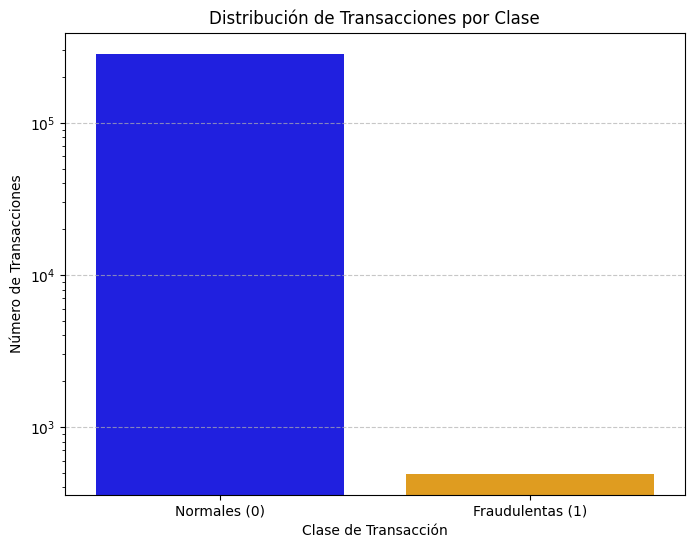

In [ ]:
# Cantidad de transacciones de clase 0 y clase 1
count_class_0, count_class_1 = df['Class'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=['Normales (0)', 'Fraudulentas (1)'],
            y=[count_class_0, count_class_1],
            palette=['blue', 'orange'])
plt.title('Distribución de Transacciones por Clase')
plt.ylabel('Número de Transacciones')
plt.xlabel('Clase de Transacción')
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Construcción del modelo

#### Compilación

In [30]:
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense

dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada)
encoder = Dense(14, activation='relu')(encoder)

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

from keras.optimizers import SGD
sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer=sgd, loss='mse')

nits = 100
tam_lote = 32
patience = 12
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

autoencoder.summary()
autoencoder.fit(X_train, X_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=0, callbacks=[early_stopping])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 14)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 29)             │           609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,803 (7.04 KB)

 Trainable params: 1,803 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

### Validación

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
(56962, 29)


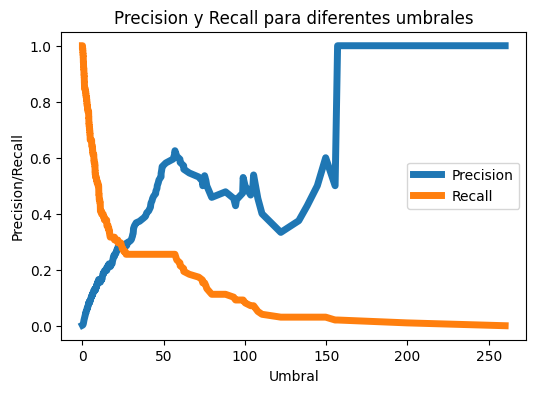

In [32]:
# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
precision, recall, umbral = precision_recall_curve(Y_test, ecm)
plt.figure(figsize=(6,4))
plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()